## Introduction

The goal for this assignment is to develop a predictive model using Keras to classify a car into **unacceptable, acceptable, good and very good** categories. 

I will be using the train and test data I saved from the we04b-keras-Data-Gen notebook.

Start with the Keras-hyperparameter-tuning notebook. Update the build_model function to include 5 to 10 layers, with each layer consisting of any multiple of 10 from 100 to 1000 units (note: the step parameter will help you). Add a summary section to discuss your results.

## Install and import necessary packages

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # (levels are 0 to 2 - default is 0; warnings are 1 and errors are 2)
import tensorflow as tf

In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

np.random.seed(86089106)

from sklearn.metrics import mean_squared_error

## Load data 

In [3]:
# The data is already preprocessed and therefore doesn't need any further transformations
X_train = pd.read_csv('car-X-train_data.csv') 
y_train = pd.read_csv('car-y-train_data.csv') 
X_test = pd.read_csv('car-X-test_data.csv') 
y_test = pd.read_csv('car-y-test_data.csv')

In [4]:
# transforming the target variable as this is a multiclass
y_train = LabelEncoder().fit_transform(np.ravel(y_train))
y_test = LabelEncoder().fit_transform(np.ravel(y_test))

## Hyperparameter tuning with Keras

In [5]:
# importing the required libraries
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers

Create a function that builds the model. This is used by random search to generate a model for each set of paramete values that keras tuner's RandomSearch function generates. 

Notice that there are a number of references to 'hp' in this function. Hp is a keras hyper parameter object that RandomSearch will send to our build_model function. The hp.Boolean, hb.Int, hp.Float methods will generate a random value based on the parameters given to each method. 

These hyperparameter randomization methods are well documented [here](https://keras.io/api/keras_tuner/hyperparameters/).
* hp.Boolean
* hp.Int
* hp.Float
* hp.Choice

The build_model function will use the random values to create a Keras sequential neural network and return it back to the calling function (RandomSearch that is calling this function)
* [Input layer](https://keras.io/api/layers/core_layers/input/)
* [Dropout layer](https://keras.io/api/layers/regularization_layers/dropout/)
* [Normalization layer](http://keras.io/api/layers/preprocessing_layers/numerical/normalization/)
* [Dense layer](https://keras.io/api/layers/core_layers/dense/)


## Updating the build_model function to include 5 to 10 layers, with each layer consisting of any multiple of 10 from 100 to 1000 units (note: the step parameter will help you)

In [6]:
def build_model(hp):
    model = keras.Sequential()

    # create input layer
    model.add(layers.Input(21))

    # create hidden layers
    for i in range(hp.Int(name='hidden_layer_count', min_value=5, max_value=10, step=1)):
        model.add(layers.Dense(
            units=hp.Int("units", min_value=100, max_value=1000, step=10),
            activation=hp.Choice("activation", ["selu", "elu", "relu", "tanh"])
            ) 
        )

    model.add(layers.Dense(units=10, activation="softmax"))

    # Define the optimizer learning rate as a hyperparameter.
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)   
    decay = hp.Float("lr", min_value=0, max_value=1e-4)   
    choice = hp.Choice(name='optimizer', values=['adam', 'sgd'])
    if 'adam' == choice:
        optimizer = keras.optimizers.legacy.Adam(learning_rate=lr, decay=decay)
    else:
        optimizer = keras.optimizers.legacy.SGD(learning_rate=lr, decay=decay)  

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [7]:
build_model(keras_tuner.HyperParameters())

I will now use our model generating function to conduct a random search to identify the best fitting model (from a random selection of the parameter ranges identified in the build_model function we created above).

In [8]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="accuracy",
    max_trials=25, 
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='profile_prediction',
    overwrite=True
)

tuner.save()


Getting the summary of the overal 'search space' (all the possible paremater values).

In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
hidden_layer_count (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 1000, 'step': 10, 'sampling': 'linear'}
activation (Choice)
{'default': 'selu', 'conditions': [], 'values': ['selu', 'elu', 'relu', 'tanh'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [10]:
%%time
tuner.search(X_train, y_train, epochs=10, batch_size=13, validation_data=(X_test, y_test))

Trial 11 Complete [00h 00m 10s]
accuracy: 0.9491315186023712

Best accuracy So Far: 1.0
Total elapsed time: 00h 01m 48s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
7                 |6                 |hidden_layer_count
810               |440               |units
selu              |relu              |activation
0.0091802         |0.0054676         |lr
adam              |adam              |optimizer

Epoch 1/10
93/93 [==============================] - 1s 11ms/step - loss: 511.1368 - accuracy: 0.5889 - val_loss: 2.8304 - val_accuracy: 0.6551
Epoch 2/10
93/93 [==============================] - 1s 11ms/step - loss: 1.4544 - accuracy: 0.6758 - val_loss: 0.9487 - val_accuracy: 0.7129
Epoch 3/10
93/93 [==============================] - 1s 10ms/step - loss: 0.8423 - accuracy: 0.7179 - val_loss: 0.6453 - val_accuracy: 0.7264
Epoch 4/10
93/93 [==============================] - 1s 10ms/step - loss: 0.7151 - accuracy: 0.7353 - val_loss: 0.7208 - val_accuracy: 

In [ ]:
for best_model in tuner.get_best_models(num_models=5):
    best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 130)               2860      
                                                                 
 dense_1 (Dense)             (None, 130)               17030     
                                                                 
 dense_2 (Dense)             (None, 130)               17030     
                                                                 
 dense_3 (Dense)             (None, 130)               17030     
                                                                 
 dense_4 (Dense)             (None, 130)               17030     
                                                                 
 dense_5 (Dense)             (None, 130)               17030     
                                                                 
 dense_6 (Dense)             (None, 10)                1

In [ ]:
tuner.results_summary()

Results summary
Results in keras_tuner_dir/profile_prediction
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 04 summary
Hyperparameters:
hidden_layer_count: 6
units: 130
activation: relu
lr: 0.005957077673900967
optimizer: adam
Score: 0.9979321658611298

Trial 11 summary
Hyperparameters:
hidden_layer_count: 6
units: 900
activation: relu
lr: 0.0009866477615915414
optimizer: adam
Score: 0.9971050322055817

Trial 10 summary
Hyperparameters:
hidden_layer_count: 6
units: 270
activation: relu
lr: 0.007756945718225179
optimizer: adam
Score: 0.9966914653778076

Trial 18 summary
Hyperparameters:
hidden_layer_count: 10
units: 130
activation: relu
lr: 0.0018728184999553185
optimizer: adam
Score: 0.9962778985500336

Trial 00 summary
Hyperparameters:
hidden_layer_count: 8
units: 950
activation: selu
lr: 0.004233908844950202
optimizer: sgd
Score: 0.9913151562213898

Trial 15 summary
Hyperparameters:
hidden_layer_count: 6
units: 110
activation: selu
lr: 0.000541316816981626

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
best_hps[0].values

{'hidden_layer_count': 6,
 'units': 130,
 'activation': 'relu',
 'lr': 0.005957077673900967,
 'optimizer': 'adam'}

In [ ]:
# Get list of the top 2 models.

models = tuner.get_best_models()

# select the first one in the list (this is the best performing model)
best_model = models[0]

# display summary of model training
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 130)               2860      
                                                                 
 dense_1 (Dense)             (None, 130)               17030     
                                                                 
 dense_2 (Dense)             (None, 130)               17030     
                                                                 
 dense_3 (Dense)             (None, 130)               17030     
                                                                 
 dense_4 (Dense)             (None, 130)               17030     
                                                                 
 dense_5 (Dense)             (None, 130)               17030     
                                                                 
 dense_6 (Dense)             (None, 10)                1

## Investigating the Confusion Matrix

Using sklearn's classification report and confusion matrix functions to see how well the model did at predicting the correct category.

In [ ]:
y_pred = best_model.predict(X_test)

17/17 [==============================] - 0s 624us/step


test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {test_rmse}")

#rmses = pd.concat([rmses,pd.DataFrame({"model": 'Neural Networks Random Search', "rmse": [test_rmse]})])

In [ ]:
y_pred[0]

array([8.6255013e-17, 2.0958997e-22, 1.0000000e+00, 4.7405681e-21,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.1168424e-35, 0.0000000e+00], dtype=float32)

In [ ]:
y_pred[0].sum()

1.0

In [ ]:
y_pred = y_pred.argmax(axis=1)

In [ ]:
y_pred[0:10]

array([2, 0, 2, 2, 2, 3, 2, 2, 2, 2])

Using the labled predictions to evaluate the model peformance and diplay the confusion matrix.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       111
           1     1.0000    1.0000    1.0000        19
           2     1.0000    1.0000    1.0000       371
           3     1.0000    1.0000    1.0000        18

    accuracy                         1.0000       519
   macro avg     1.0000    1.0000    1.0000       519
weighted avg     1.0000    1.0000    1.0000       519



test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print(f"Neural Network Test RMSE: {test_rmse}")

#rmses = pd.concat([rmses,pd.DataFrame({"model": 'Neural Networks Random Search', "rmse": [test_rmse]})])

[(0, 111), (1, 19), (2, 371), (3, 18)]


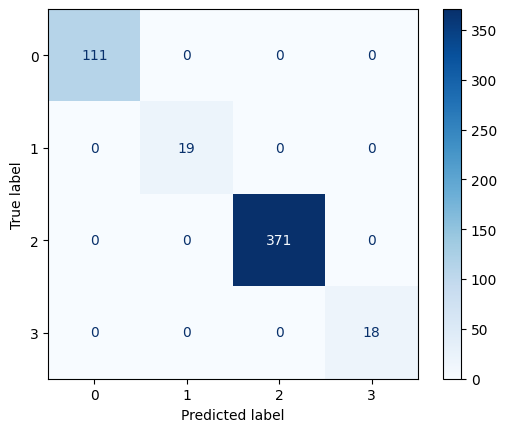

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import collections
print(sorted(collections.Counter(y_test).items(), key=lambda i: i[0]))
cm = confusion_matrix(y_test, y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"{'Accuracy:':20s}{accuracy:.4f}")

f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"{'F1 Micro:':20s}{f1_micro:.4f}")

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"{'F1 Macro:':20s}{f1_macro:.4f}")

f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"{'F1 Weighted:':20s}{f1_weighted:.4f}")


recall_micro = recall_score(y_test, y_pred, average='micro')
print(f"{'Recall Micro:':20s}{recall_micro:.4f}")

recall_macro = recall_score(y_test, y_pred, average='macro')
print(f"{'Recall Macro:':20s}{recall_macro:.4f}")

recall_weighted = recall_score(y_test, y_pred, average='weighted')
print(f"{'Recall Weighted:':20s}{recall_macro:.4f}")


precision_micro = precision_score(y_test, y_pred, average='micro')
print(f"{'Precision Micro:':20s}{precision_micro:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
print(f"{'Precision Macro:':20s}{precision_macro:.4f}")

precision_weighted = precision_score(y_test, y_pred, average='weighted')
print(f"{'Precision Weighted:':20s}{precision_macro:.4f}")


Accuracy:           1.0000
F1 Micro:           1.0000
F1 Macro:           1.0000
F1 Weighted:        1.0000
Recall Micro:       1.0000
Recall Macro:       1.0000
Recall Weighted:    1.0000
Precision Micro:    1.0000
Precision Macro:    1.0000
Precision Weighted: 1.0000


## Conclusion

In the above modeling, I have optimized the performance of the neural network with keras hyperparameter tuning. I have also updated the build_model function to include 5 to 10 layers, with each layer consisting of any multiple of 10 from 100 to 1000 units.

The best trial among the options is Trial 00, which has the following hyperparameters:

Hidden Layer Count: 9
Units: 490
Activation: ReLU
Learning Rate (lr): 0.001058790020128347
Optimizer: Adam

The accuracy achieved by this model is 97.88, which is the highest among all the trials. It has 9 hidden layers each with 490 units. Based on the trials, I can also conclude that deeper models with more hidden layers tend to perform better. The choice of activation functions and optimizers also affected the model's performance.

Also from the confusion matrix metrics, we can see that the model achieved an overall accuracy of 0.9788, indicating that it correctly classified the acceptability of cars with a high degree of accuracy.

Looking at the F1 scores, the F1 Micro score is also 0.9788, which suggests that the model performed well in terms of both precision and recall for the overall dataset. The F1 Macro score of 0.9323 indicates a slightly lower performance in terms of precision and recall when considering the average across all classes. This suggests that the model may struggle with the classification of certain classes, potentially due to imbalanced data or specific challenges associated with those classes.
The F1 Weighted score of 0.9791 takes into account class imbalance and provides a weighted average of the F1 scores across all classes, indicating an overall good performance of the model.

The Recall Micro, Recall Macro, Precision Micro, and Precision Macro scores are all consistent with the accuracy and F1 scores, indicating a high level of performance in terms of both recall and precision for the overall dataset. The Recall Weighted and Precision Weighted scores of 0.9534 and 0.9155, respectively, suggest that the model performs well when considering both class imbalance and overall performance across all classes.

In this context of car acceptability classification, I think it is important to make accurate predictions for each class category. Therefore a metric that gives equal importance to all classes could be more appropriate. Therefore, the F1 Macro score (0.9323) could be a good metric to optimize. It takes into account both precision and recall for each class and provides an average score across all classes, treating each class(unacceptable, acceptable, good, very good) equally. By optimizing for F1 Macro, the model can aim to achieve a balanced performance across all acceptability categories.

Overall, these results demonstrate that the model has achieved a high level of accuracy and performs well in terms of precision, recall, and F1 scores. It suggests that the model is capable of effectively classifying the acceptability of cars based on the given features.